# Categorical ATE Estimation: Strange Behaviour

In this notebook, I will estimate the effect of three different drugs on the heart rate of individuals. I want to make a comparison between each drug by estimating the causal effect of taking one drug instead of another. I will do this using a linear regression model.

In [168]:
from dowhy import CausalModel
from itertools import combinations
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("tableau-colorblind10")

First, we will create the variables and a causal graph.

In [169]:
treatment = "Drug"
treatments = ["1", "2", "3", "4"]  # Different versions of drug (treatment levels to compare)
outcome = "Heart Rate"
confounders = ["Age", "Weight"]
causal_graph = """digraph{"Drug"->"Heart Rate";"Age"->"Drug";"Age"->"Heart Rate";"Weight"->"Drug";"Weight"->"Heart Rate";}"""

Next, we will simulate some data that matches the causal graph. We will make drug 1 have a positive effect of 20 on heart rate and drug 2 have a negative effect of 20 on heart rate. Drugs 3 and 4 will have no effect.

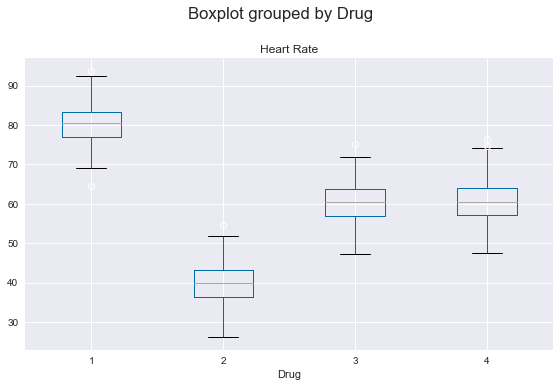

In [170]:
df = pd.DataFrame({"Drug": [], "Heart Rate": [], "Age": [], "Weight": []})
n_subjects = 1000
for n in range(n_subjects):
    age = abs(np.random.normal(40, 10))
    weight = abs(np.random.normal(70, 10))
    heart_rate = abs(np.random.normal(60, 5))
    if age > 60:
        heart_rate * (1 + age/200)
    if weight > 90:
        heart_rate * (1 + weight/200)
    drug = np.random.choice(["1", "2", "3", "4"])
    if drug == "1":
        heart_rate += 20
    elif drug == "2":
        heart_rate -= 20
    df = df.append({"Drug": drug, "Heart Rate": heart_rate, "Age": age, "Weight": weight}, ignore_index=True)
df["Drug"] = df["Drug"].astype("category")
df = df.sort_values(by=["Drug"])
df.boxplot(by="Drug", column="Heart Rate")
plt.tight_layout()

Now let's do the causal inference.

{('1', '2'): -3.3624,
 ('1', '3'): -6.7249,
 ('1', '4'): -10.0873,
 ('2', '3'): -3.3624,
 ('2', '4'): -6.7249,
 ('3', '4'): -3.3624}


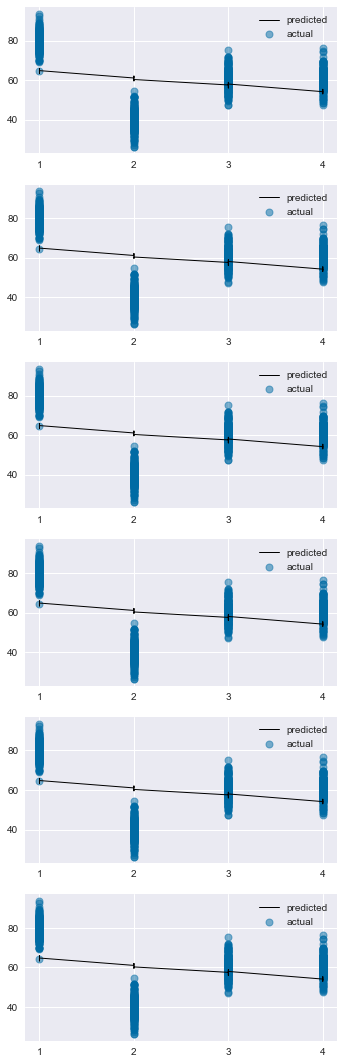

In [171]:
causal_model = CausalModel(df, "Drug", "Heart Rate", causal_graph)
causal_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)

# Compare each unique pair of drugs:
control_treatment_pairs = combinations(["1", "2", "3", "4"], 2)
causal_estimates = {}
fig, ax = plt.subplots(6, figsize=(5,15))

for i, control_treatment_pair in enumerate(control_treatment_pairs):
    control_value, treatment_value = control_treatment_pair
    causal_estimate = causal_model.estimate_effect(causal_estimand, method_name="backdoor.linear_regression",
                                                   control_value=control_value, treatment_value=treatment_value)
    linear_model = causal_estimate.estimator.model
    ax[i].plot(df["Drug"], linear_model.predict(), label='predicted', color="black", linewidth=1)
    ax[i].scatter(df["Drug"], df["Heart Rate"], alpha=0.5, label='actual', linewidth=1)
    ax[i].legend()
    causal_estimates[(control_value, treatment_value)] = (round(causal_estimate.value, 4))

pprint(causal_estimates)

plt.legend()
plt.tight_layout()

These results are wrong. The estimate is based on the numerical difference between the category values and is not the difference between the average heart rate of those that received control and treatment. This can be seen in the graphs above where the same linear model is used for each comparison.

As a result ('1', '2'), ('2', '3'), and ('3', '4') yield -4.0258 because they all increase by one. On the other hand, ('1', '3') and ('2', '4') both yield -8.0516 because they increase by two.

However, if we split the original dataframes for each comparison, we get the expected results.

{('1', '2'): -40.1552,
 ('1', '3'): -19.6385,
 ('1', '4'): -19.5511,
 ('2', '3'): 20.5176,
 ('2', '4'): 20.5615,
 ('3', '4'): 0.0436}


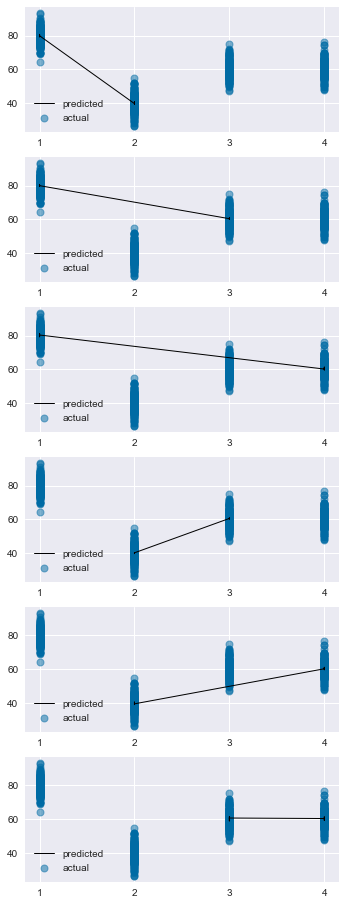

In [174]:
control_treatment_pairs = combinations(["1", "2", "3", "4"], 2)
causal_estimates = {}
fig, ax = plt.subplots(6, figsize=(5,15))
for i, control_treatment_pair in enumerate(control_treatment_pairs):
    control_value, treatment_value = control_treatment_pair
    new_df = df.loc[df["Drug"].isin([control_value, treatment_value])]
    causal_model = CausalModel(new_df, "Drug", "Heart Rate", causal_graph)
    causal_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)
    causal_estimate = causal_model.estimate_effect(causal_estimand, method_name="backdoor.linear_regression",
                                                   control_value=control_value, treatment_value=treatment_value)
    linear_model = causal_estimate.estimator.model
    ax[i].scatter(df["Drug"], df["Heart Rate"], alpha=0.5, label='actual', linewidth=1)
    ax[i].plot(new_df["Drug"], linear_model.predict(), label='predicted', color="black", linewidth=1)
    
    ax[i].legend()
    causal_estimates[(control_value, treatment_value)] = round(causal_estimate.value, 4)

pprint(causal_estimates)